<a href="https://colab.research.google.com/github/felixzhao/Vac-Attack/blob/main/V1_asb_challenge_final_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

## Goals
The goal of this task is to create a forecast of sales expected December 2020 as well as the total expected of the month based on the historical data.

The second goal is to give an insight from the model or data (expecialy around advertisting spend)

## What has been done in this notebook

There are several types of time series forecasting:
univariate, multivariat and multiple time series forcasting.

In the following sections a data analsysis has been done.
We can see, the "AdvertisingSpend" has a correlation with the "Sales", and "Covid19-lockdown" has negative correlation with the "Sales".

## Forecasting approach

These approaches have been introduced in this work.
1. ARIMA is a traditional approach which is popular in Time Series Forecasting. In this work, we use it only for univariate forecassting.

2. Facebook Prophet is a powerful high level API for time series forecasting. In this work, we use it for a multivarite time series forecasting and have done the following tasks. 
  
  - Handle the "Covid19_lockdown", following Prophet official documentation, which treats the days impacted by Covid19 as holidays that will not repeat again in the future.
  - Add correlated feature "AdvertisingSpend" into the model
  - Evaluate model using Cross Validation
  - Infer the model with "AdvertisingSpend" feature 
3. DNN, in this work we use Tensorflow to create a model from scratch combining CNN and LSTM. This model is used for univariate forecassting.





In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib as mpl

In [ ]:
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [ ]:
import tensorflow as tf

# Data preparation

This work loads data from google drive.
Please put the files into "Vac_Attack" folder under the root of google drive.

Then run the following code to mount the google drive in colab.

You can follow the guide.
https://towardsdatascience.com/different-ways-to-connect-google-drive-to-a-google-colab-notebook-pt-1-de03433d2f7a

In [185]:
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## MarketingSales

In [ ]:
marketing_cols = pd.read_csv("drive/MyDrive/Vac_Attack/MarketingCols.csv", header=None)
m_cols = [x[0] for x in marketing_cols.to_numpy().tolist()]
raw = pd.read_csv("drive/MyDrive/Vac_Attack/MarketingSales.csv", header=None, names=m_cols)
raw.head(2)

,Date,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,Sales
0,1/01/16,0,0,0,4199.86,January,Friday,1,0,0,66
1,2/01/16,0,0,0,14768.20,January,Saturday,1,0,0,84


In [ ]:
raw['ds'] = pd.to_datetime(raw.Date)
raw['y'] = raw.Sales
raw_df = raw.drop(['Date', 'Sales'], axis=1)

raw_df.head(2)

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,Month,Day,0508Line_247,UltraEdition_Available,COVID_Lockdown,ds,y
0,0,0,0,4199.86,January,Friday,1,0,0,2016-01-01,66
1,0,0,0,14768.20,January,Saturday,1,0,0,2016-02-01,84


In [ ]:
raw_df.columns

Index(['PositiveNews', 'NegativeCoverage', 'Competition', 'AdvertisingSpend',
       'Month', 'Day', '0508Line_247', 'UltraEdition_Available',
       'COVID_Lockdown', 'ds', 'y'],
      dtype='object')

## DecemberAdData

In [ ]:
dec_cols = pd.read_csv("drive/MyDrive/Vac_Attack/DecemberCols.csv", header=None)
d_cols = [x[0] for x in dec_cols.to_numpy().tolist()]
dec_adv = pd.read_csv("drive/MyDrive/Vac_Attack/DecemberAdData.csv", header=None, names=d_cols)
dec_adv.head(2)

,Date,AdvertisingSpend,Month,Day
0,1/12/20,10568.28,December,Tuesday
1,2/12/20,8218.31,December,Wednesday


In [ ]:
dec_adv['ds'] = pd.to_datetime(dec_adv.Date)
raw_adv = raw[['ds','AdvertisingSpend', 'Month', 'Day']]
dec_adv_temp = dec_adv[['ds','AdvertisingSpend', 'Month', 'Day']]
forecasting_feaure = pd.concat([raw_adv, dec_adv_temp])
print(f"{len(raw_adv)}, {len(dec_adv)}, {len(forecasting_feaure)}")
forecasting_feaure.tail()

1796, 31, 1827


,ds,AdvertisingSpend,Month,Day
26,2020-12-27,964.54,December,Sunday
27,2020-12-28,578.13,December,Monday
28,2020-12-29,29203.62,December,Tuesday
29,2020-12-30,12686.89,December,Wednesday
30,2020-12-31,9415.00,December,Thursday


# Correlation Analysis

There are two features correlated with the Sales,
Which are AdvertisingSpend 0.41 and COVID_Lockdown -0.40


In [ ]:
raw_df.corr()

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,0508Line_247,UltraEdition_Available,COVID_Lockdown,y
PositiveNews,1.00,-0.02,-0.01,0.02,0.02,-0.02,0.01,0.12
NegativeCoverage,-0.02,1.00,-0.01,-0.01,-0.01,-0.01,-0.02,-0.07
Competition,-0.01,-0.01,1.00,-0.02,-0.36,0.55,0.32,-0.11
AdvertisingSpend,0.02,-0.01,-0.02,1.00,0.02,-0.01,-0.02,0.41
0508Line_247,0.02,-0.01,-0.36,0.02,1.00,-0.65,-0.11,0.18
UltraEdition_Available,-0.02,-0.01,0.55,-0.01,-0.65,1.00,0.18,-0.12
COVID_Lockdown,0.01,-0.02,0.32,-0.02,-0.11,0.18,1.00,-0.40
y,0.12,-0.07,-0.11,0.41,0.18,-0.12,-0.40,1.00




The CCF values of AdvertisingSpend and Sales are positive and have a peak at a certain lag, which means that the two series are positively correlated and that there is a delay in one of the series relative to the other.

In [ ]:
lags = range(-len(raw_df)+1, len(raw_df))
ccf = np.correlate(raw_df['AdvertisingSpend'], raw_df['y'], mode='full')

Text(0, 0.5, 'CCF')

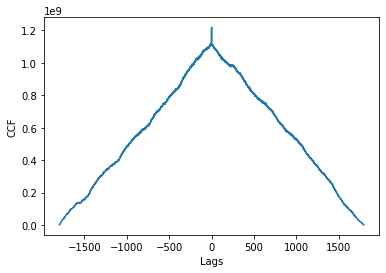

In [ ]:
plt.plot(lags, ccf)
plt.xlabel('Lags')
plt.ylabel('CCF')

# Data exploration

In [ ]:
raw_df.describe()

,PositiveNews,NegativeCoverage,Competition,AdvertisingSpend,0508Line_247,UltraEdition_Available,COVID_Lockdown,y
count,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00,1796.00
mean,0.03,0.01,0.23,7900.03,0.30,0.49,0.03,78.70
std,0.18,0.09,0.42,6235.05,0.46,0.50,0.17,22.36
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00
25%,0.00,0.00,0.00,2953.03,0.00,0.00,0.00,64.00
50%,0.00,0.00,0.00,6583.47,0.00,0.00,0.00,77.00
75%,0.00,0.00,0.00,11558.74,1.00,1.00,0.00,92.00
max,1.00,1.00,1.00,46586.07,1.00,1.00,1.00,163.00


In [ ]:
raw_df.isna().sum()

PositiveNews              0
NegativeCoverage          0
Competition               0
AdvertisingSpend          0
Month                     0
Day                       0
0508Line_247              0
UltraEdition_Available    0
COVID_Lockdown            0
ds                        0
y                         0
dtype: int64

In [ ]:
px.scatter(raw_df, x='AdvertisingSpend', y='y', trendline = 'ols', trendline_color_override='red')

In [ ]:
a = raw.copy()
a['year'] = a.ds.dt.year
a['dayofweek'] = a.ds.dt.dayofweek + 1
a = a.groupby(['year', 'dayofweek']).y.mean().reset_index()
px.line(a, x='dayofweek', y='y', color='year', title='Sales')

In [ ]:
a = raw.set_index("ds").groupby("PositiveNews").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "PositiveNews", title = "Monthly total sales with Positive News.")

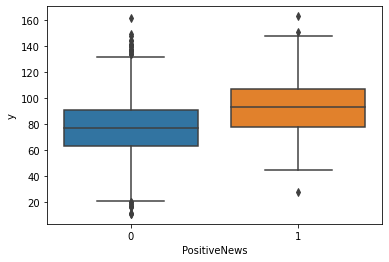

In [ ]:
sns.boxplot(data=raw_df, x='PositiveNews', y='y')

In [ ]:
a = raw.set_index("ds").groupby("NegativeCoverage").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "NegativeCoverage", title = "Monthly total sales of NegativeCoverage.")

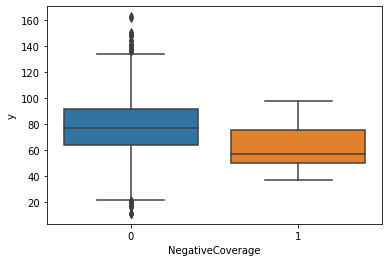

In [ ]:
sns.boxplot(data=raw_df, x='NegativeCoverage', y='y')

In [ ]:
a = raw.set_index("ds").groupby("Competition").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "Competition", title = "Monthly total sales of Competition.")

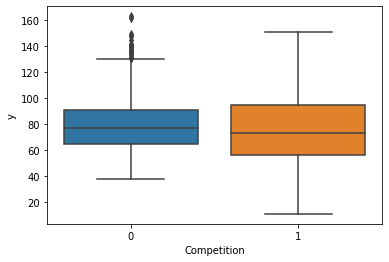

In [ ]:
sns.boxplot(data=raw_df, x='Competition', y='y')

In [ ]:
a = raw.set_index("ds").groupby("COVID_Lockdown").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "COVID_Lockdown", title = "Monthly total sales of COVID Lockdown.")

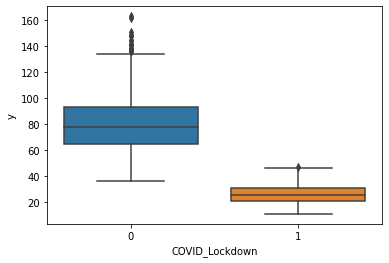

In [ ]:
sns.boxplot(data=raw_df, x='COVID_Lockdown', y='y')

In [ ]:
a = raw.set_index("ds").groupby("0508Line_247").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "0508Line_247", title = "Monthly total sales of 0508Line 2*47.")

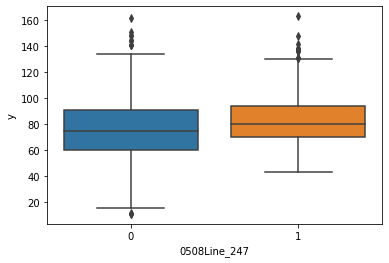

In [ ]:
sns.boxplot(data=raw_df, x='0508Line_247', y='y')

In [ ]:
a = raw.set_index("ds").groupby("UltraEdition_Available").resample("M").y.sum().reset_index()
px.line(a, x = "ds", y= "y", color = "UltraEdition_Available", title = "Monthly total sales of UltraEdition_Avaliable.")

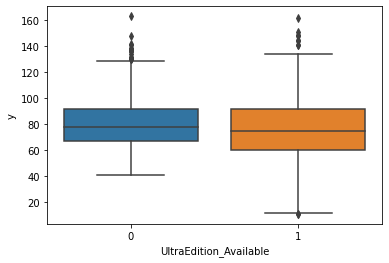

In [ ]:
sns.boxplot(data=raw_df, x='UltraEdition_Available', y='y')

In [ ]:
mpl.rc("figure", figsize=(100,10))

## ACF and PACF

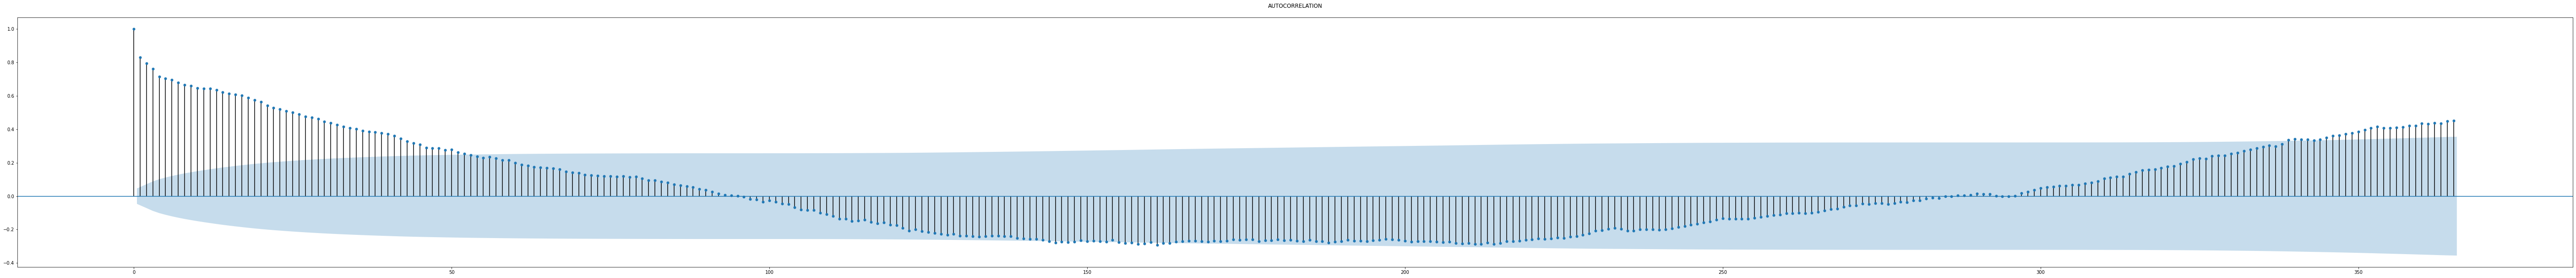

In [ ]:
lags = 365
t = sm.graphics.tsa.plot_acf(raw.Sales, lags=lags,  title = "AUTOCORRELATION\n")

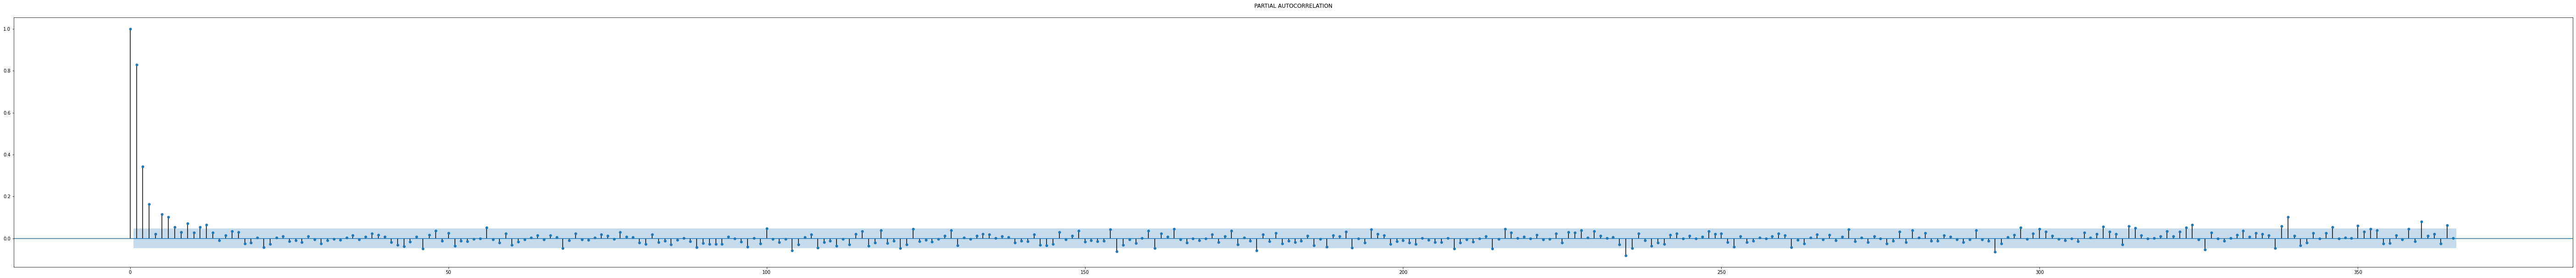

In [ ]:
t = sm.graphics.tsa.plot_pacf(raw.Sales, lags=lags, title = "PARTIAL AUTOCORRELATION\n")

# Forecasting

## ARIMA

In [ ]:
arima_raw = raw_df.copy()
arima_df = arima_raw[['ds','y']]
arima_df.tail(2)

,ds,y
1794,2020-11-29,98
1795,2020-11-30,94


In [ ]:
arima_df = arima_df.set_index('ds')
arima_df.tail(2)

,y
ds,
2020-11-29,98
2020-11-30,94


In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 55.2 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [ ]:
import pmdarima as pm

In [ ]:
m = pm.auto_arima(arima_df['y'], m=12, seasonal=True, start_p=0, start_q=0, max_order=4, test='adf', 
                  error_action='ignore', suppress_warnings=True, stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=10.66 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16261.390, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=14163.888, Time=6.22 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=14968.755, Time=4.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=20919.673, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=14178.330, Time=0.30 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=14158.870, Time=10.84 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=14156.365, Time=20.15 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=14154.335, Time=6.53 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=14165.974, Time=2.31 sec
 ARIMA(1,0,0)(1,0,2)[12] intercept   : AIC=14156.322, Time=21.93 sec
 ARIMA(1,0,0)(0,0,2)[12] intercept   : AIC=14161.209, Time=7.99 sec
 ARIMA(1,0,0)(2,0,2)[12] intercept   : AIC=14156.686, Time=28.64 sec
 ARIMA(2,0,0)(1,0,1)[12] intercept   : AIC=13949.572, Time=4.95 sec
 ARIMA

In [ ]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1796
Model:             SARIMAX(3, 0, 1)x(0, 0, 1, 12)   Log Likelihood               -6924.910
Date:                            Mon, 23 Jan 2023   AIC                          13863.820
Time:                                    06:54:24   BIC                          13902.274
Sample:                                         0   HQIC                         13878.016
                                           - 1796                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8112      0.294      2.755      0.006       0.234       1.388
ar.L1          1.2896      0.042     30.678      0.000       1.207       1.372
ar.L2         -0.1628      0.037     -4.374      0.000      -0.236      -0.090
ar.L3         -0.1371      0.033     -4.212      0.000      -0.201      -0.073
ma.L1         -0.8338      0.035    -23.589      0.000      -0.903      -0.765
ma.S.L12       0.0416      0.025      1.661      0.097      -0.007       0.091
sigma2       130.4184      3.267     39.923      0.000     124.016     136.821
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               307.08
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.40
Prob(H) (two-sided):                  0.79   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
m.fit(arima_df['y'])
forecast = m.predict(n_periods=31, return_conf_int=True)
forecast

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



(1796   96.20
 1797   95.95
 1798   96.09
 1799   95.94
 1800   96.45
 1801   95.54
 1802   95.29
 1803   94.73
 1804   94.71
 1805   95.11
 1806   94.14
 1807   93.67
 1808   93.51
 1809   93.25
 1810   93.00
 1811   92.74
 1812   92.49
 1813   92.23
 1814   91.98
 1815   91.74
 1816   91.50
 1817   91.26
 1818   91.02
 1819   90.80
 1820   90.57
 1821   90.35
 1822   90.13
 1823   89.92
 1824   89.71
 1825   89.51
 1826   89.31
 dtype: float64, array([[ 73.8123155 , 118.57823059],
        [ 71.3538646 , 120.55086554],
        [ 69.71850953, 122.46650637],
        [ 68.50510656, 123.36554925],
        [ 68.20059974, 124.70922682],
        [ 66.61557882, 124.47059802],
        [ 65.77294465, 124.805036  ],
        [ 64.68228794, 124.77659539],
        [ 64.1741517 , 125.24823132],
        [ 64.1191465 , 126.10826906],
        [ 62.71212361, 125.56244568],
        [ 61.84096973, 125.5056321 ],
        [ 61.13863616, 125.88914076],
        [ 60.44404716, 126.05676006],
        [ 59.78752

In [ ]:
forecast_range=pd.date_range(start='2020-12-01', periods=31, freq='D')
forecast_range

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
forecast_df = pd.DataFrame(data=forecast[0].tolist(), index=forecast_range, columns=['pred'])
forecast_df

,pred
2020-12-01,96.20
2020-12-02,95.95
2020-12-03,96.09
2020-12-04,95.94
2020-12-05,96.45
2020-12-06,95.54
2020-12-07,95.29
2020-12-08,94.73
2020-12-09,94.71
2020-12-10,95.11


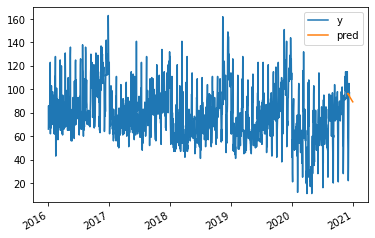

In [ ]:
pd.concat([arima_df['y'], forecast_df], axis=1).plot()

Based on diagnostics QQ plot, we can see the residual of the model is following Normal Distribution.

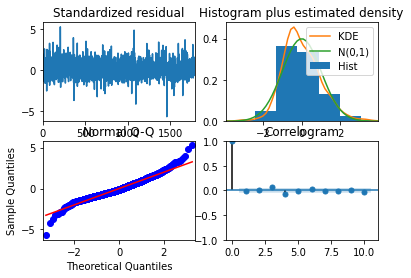

In [ ]:
out = m.plot_diagnostics()

### DEC sales prediction by ARIMA

In [ ]:
print(f"total expected of Sales by ARIMA in Dec: {forecast_df.pred.sum()}")
forecast_df

total expected of Sales by ARIMA in Dec: 2878.8513926731985


,pred
2020-12-01,96.20
2020-12-02,95.95
2020-12-03,96.09
2020-12-04,95.94
2020-12-05,96.45
2020-12-06,95.54
2020-12-07,95.29
2020-12-08,94.73
2020-12-09,94.71
2020-12-10,95.11


## Prophet

### handle COV-19 period

To prevent large dips and spikes from being captured by the trend component, we can treat the days impacted by COVID-19 as holidays that will not repeat again in the future. We set up a DataFrame like so to describe the periods affected by lockdowns:

from: https://facebook.github.io/prophet/docs/handling_shocks.html#treating-covid-19-lockdowns-as-a-one-off-holidays

In [ ]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-25', 'lower_window': 0, 'ds_upper': '2020-05-15'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

,holiday,ds,lower_window,ds_upper,upper_window
0,lockdown_1,2020-03-25,0,2020-05-15,51


In [ ]:
m = Prophet(holidays=lockdowns, interval_width=0.95, yearly_seasonality=True)
m.add_regressor('AdvertisingSpend')
m.fit(raw_df)
forecast = m.predict(forecasting_feaure)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/a_ecztcc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/eyc6lq8o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43995', 'data', 'file=/tmp/tmpdd4mh7r6/a_ecztcc.json', 'init=/tmp/tmpdd4mh7r6/eyc6lq8o.json', 'output', 'file=/tmp/tmpdd4mh7r6/prophet_modeluo55dqqu/prophet_model-20230123070741.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:07:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:07:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
1822,2020-12-27,89.57,62.46,119.33
1823,2020-12-28,88.10,58.64,119.58
1824,2020-12-29,125.82,94.62,154.79
1825,2020-12-30,100.74,70.90,129.40
1826,2020-12-31,94.35,65.47,125.05


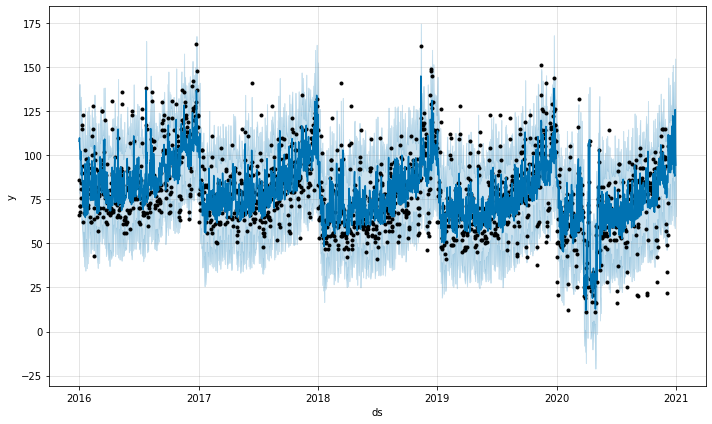

In [ ]:
fig1 = m.plot(forecast)

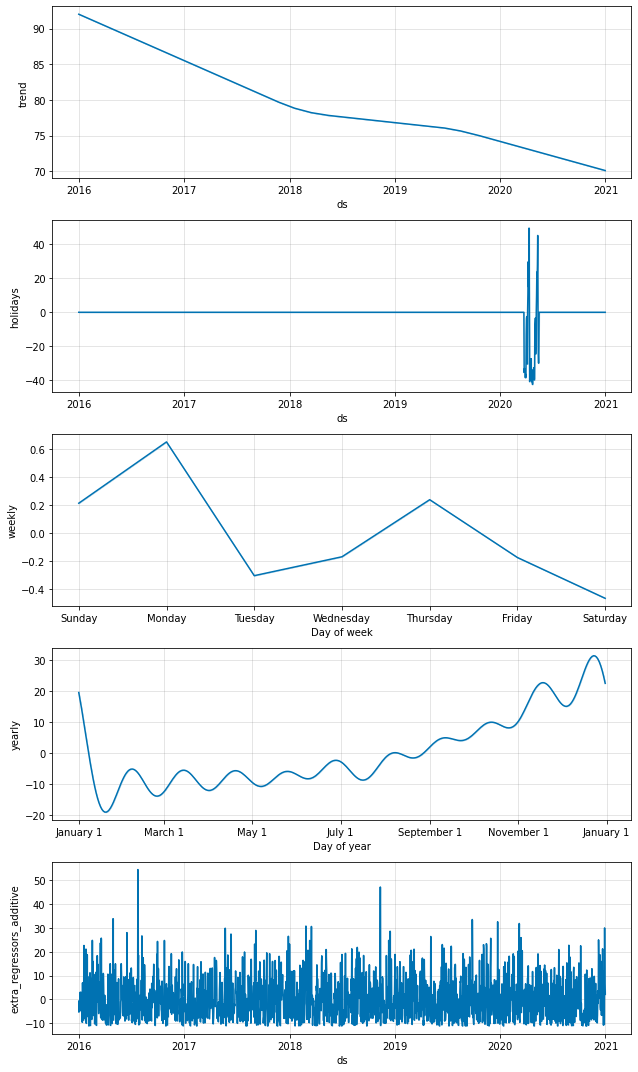

In [ ]:
fig2 = m.plot_components(forecast)

In [ ]:
plot_plotly(m, forecast)

In [ ]:
plot_components_plotly(m, forecast)

### Prophet Cross Validation

In [ ]:
cv_result = cross_validation(model=m, horizon="300 days")
cv_result

INFO:prophet:Making 5 forecasts with cutoffs between 2018-06-25 00:00:00 and 2020-02-15 00:00:00


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/cs7w6r0_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/pmxwxodk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84677', 'data', 'file=/tmp/tmpdd4mh7r6/cs7w6r0_.json', 'init=/tmp/tmpdd4mh7r6/pmxwxodk.json', 'output', 'file=/tmp/tmpdd4mh7r6/prophet_modell499iobf/prophet_model-20230123071237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/z0h8yuw9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdd4mh7r6/uzp3k_5n.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-06-26,67.48,41.87,93.74,58,2018-06-25
1,2018-06-27,88.76,61.16,115.91,71,2018-06-25
2,2018-06-28,61.78,34.11,88.35,60,2018-06-25
3,2018-06-29,82.16,55.61,110.42,71,2018-06-25
4,2018-06-30,70.51,42.71,98.79,69,2018-06-25
...,...,...,...,...,...,...
1477,2020-12-07,93.43,65.20,120.11,73,2020-02-15
1478,2020-12-08,118.17,88.17,146.62,105,2020-02-15
1479,2020-12-09,109.97,81.26,139.08,103,2020-02-15
1480,2020-12-10,100.10,71.66,127.11,94,2020-02-15


Based on the Prophet Cross Validation result the RMSE of 31 days is 17.58

In [ ]:
df_p = performance_metrics(cv_result)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,30 days,312.59,17.68,13.62,0.19,0.13,0.18,0.84
1,31 days,309.02,17.58,13.40,0.19,0.12,0.17,0.84
2,32 days,305.79,17.49,13.25,0.18,0.12,0.17,0.84
3,33 days,304.00,17.44,13.16,0.18,0.12,0.17,0.84
4,34 days,302.25,17.39,13.02,0.18,0.12,0.17,0.84
...,...,...,...,...,...,...,...,...
266,296 days,321.68,17.94,12.56,0.25,0.12,0.19,0.89
267,297 days,326.67,18.07,12.70,0.25,0.12,0.19,0.88
268,298 days,324.08,18.00,12.61,0.25,0.12,0.19,0.89
269,299 days,323.98,18.00,12.65,0.25,0.12,0.19,0.89


In [ ]:
prophet_dec = forecast[['ds', 'yhat']].tail(31)

### DEC sales prediction by Prophet

In [ ]:
print(f"total expected of Sales by ARIMA in Dec:{prophet_dec.yhat.sum()}")
prophet_dec

total expected of Sales by ARIMA in Dec:3009.315445289681


,ds,yhat
1796,2020-12-01,87.57
1797,2020-12-02,82.73
1798,2020-12-03,75.83
1799,2020-12-04,78.66
1800,2020-12-05,88.65
1801,2020-12-06,84.30
1802,2020-12-07,87.80
1803,2020-12-08,111.63
1804,2020-12-09,103.29
1805,2020-12-10,93.72


## DNN

### Utilities

In [ ]:
def plot_series(x, y, format="-", start=0, end=None, 
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))
    
    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    # plt.show()

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

### data preparation

In [ ]:
time = raw_df.ds.to_numpy()
series = raw_df.y.to_numpy()

In [ ]:
# Define the split time
split_time = len(series) - 31

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
# Parameters
window_size = 31
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

### Build the Model

In [ ]:
# Build the Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                      strides=1,
                      activation="relu",
                      padding='causal',
                      input_shape=[window_size, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

 # Print the model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 31, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 31, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
 lambda (Lambda)             (None, 1)                 0

### Tune the Learning Rate

In [ ]:
# Get initial weights
init_weights = model.get_weights()

# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])

Epoch 1/20
55/55 [==============================] - 6s 41ms/step - loss: 301.6187 - lr: 1.0000e-08
Epoch 2/20
55/55 [==============================] - 2s 42ms/step - loss: 213.8299 - lr: 1.1220e-08
Epoch 3/20
55/55 [==============================] - 2s 41ms/step - loss: 164.3795 - lr: 1.2589e-08
Epoch 4/20
55/55 [==============================] - 2s 41ms/step - loss: 124.1072 - lr: 1.4125e-08
Epoch 5/20
55/55 [==============================] - 2s 40ms/step - loss: 81.7841 - lr: 1.5849e-08
Epoch 6/20
55/55 [==============================] - 2s 40ms/step - loss: 42.6262 - lr: 1.7783e-08
Epoch 7/20
55/55 [==============================] - 2s 41ms/step - loss: 17.2656 - lr: 1.9953e-08
Epoch 8/20
55/55 [==============================] - 2s 40ms/step - loss: 13.4517 - lr: 2.2387e-08
Epoch 9/20
55/55 [==============================] - 2s 41ms/step - loss: 13.2498 - lr: 2.5119e-08
Epoch 10/20
55/55 [==============================] - 2s 41ms/step - loss: 13.0747 - lr: 2.8184e-08
Epoch 11/20
55/

(1e-08, 0.001, 0.0, 20.0)

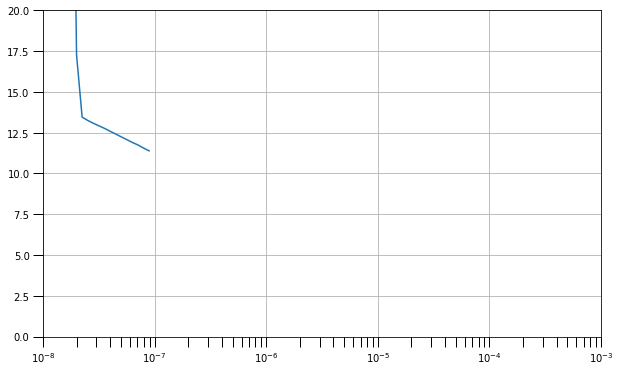

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(20) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 20])

### Train the Model

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [ ]:
# Set the learning rate
learning_rate = 10e-7

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
# Train the model
history = model.fit(train_set,epochs=20)

Epoch 1/20
55/55 [==============================] - 6s 41ms/step - loss: 50.7199 - mae: 51.2138
Epoch 2/20
55/55 [==============================] - 2s 40ms/step - loss: 11.8047 - mae: 12.2962
Epoch 3/20
55/55 [==============================] - 2s 40ms/step - loss: 10.3724 - mae: 10.8615
Epoch 4/20
55/55 [==============================] - 2s 40ms/step - loss: 9.7530 - mae: 10.2431
Epoch 5/20
55/55 [==============================] - 2s 41ms/step - loss: 9.3792 - mae: 9.8648
Epoch 6/20
55/55 [==============================] - 2s 40ms/step - loss: 9.4609 - mae: 9.9514
Epoch 7/20
55/55 [==============================] - 2s 41ms/step - loss: 9.4361 - mae: 9.9251
Epoch 8/20
55/55 [==============================] - 2s 40ms/step - loss: 9.2716 - mae: 9.7605
Epoch 9/20
55/55 [==============================] - 2s 40ms/step - loss: 9.2298 - mae: 9.7177
Epoch 10/20
55/55 [==============================] - 2s 40ms/step - loss: 9.1526 - mae: 9.6415
Epoch 11/20
55/55 [==============================] -

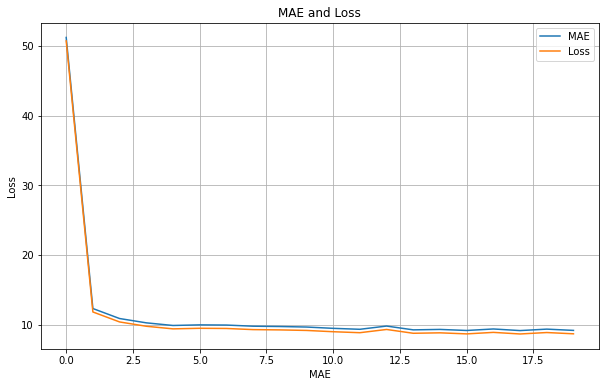

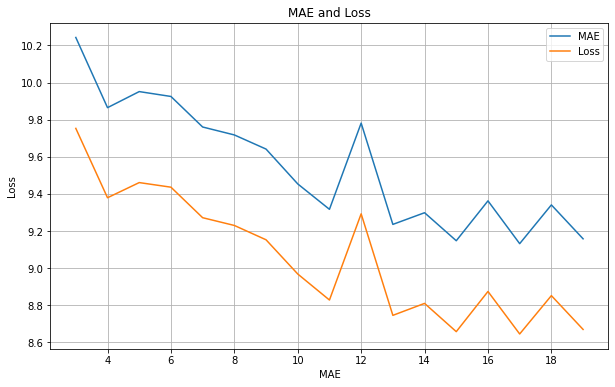

In [ ]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_series(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_series(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

### validation

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

1/1 [==============================] - 1s 1s/step


In [ ]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

6.865936


In [ ]:
print(len(results))
results[:31]

31


array([ 93.14128 ,  92.9933  ,  93.32771 ,  96.4871  , 101.54041 ,
       100.34151 ,  96.18838 ,  97.58449 ,  96.085785,  93.63751 ,
        93.68463 ,  92.919304,  93.38849 ,  95.58237 ,  96.428696,
        96.0285  ,  99.94907 , 101.197266, 100.26987 , 103.28939 ,
       103.8534  , 102.519844, 101.97881 , 101.66141 , 105.176796,
       104.824   , 102.54118 , 101.39147 , 101.56486 , 105.32716 ,
       105.0134  ], dtype=float32)

In [ ]:
len(x_valid)

31

In [ ]:
forecast_range=pd.date_range(start='2020-12-01', periods=31, freq='D')
forecast_range

DatetimeIndex(['2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', freq='D')

In [ ]:
forecast_df = pd.DataFrame(results, index=forecast_range, columns=['yhat'])

### DEC sales prediction by DNN

In [ ]:
print(f"total expected of Sales by DNN in Dec:{forecast_df.yhat.sum()}")
forecast_df

total expected of Sales by DNN in Dec:3069.91748046875


,yhat
2020-12-01,93.14
2020-12-02,92.99
2020-12-03,93.33
2020-12-04,96.49
2020-12-05,101.54
2020-12-06,100.34
2020-12-07,96.19
2020-12-08,97.58
2020-12-09,96.09
2020-12-10,93.64


# conculsion


The Total Sales in december prediction from ARIMA is 2878.85, from Prophet is 3009.32 and from DNN is 3069.92, which are close in value.

ARIMA is a traditional method and DNN can be used to  create model from scrach which gives more flexibility.
Both ARIMA and DNN take long time to run,  so in this work we only use them for univariate forecasting to reduce complexity.

If we have more time, we can refine the DNN model.

Prophet is the easiest way to use and it takes shorter time to run than other two approaches. That's why in this work it has been adopted for the multivarite forecasting work and handling the Covid19-lockdown.

At last, the "PositiveNews", "NegativeCoverage","Competition", "0508Line_247" and "UltraEdition_Available" are not included in the model.

The first reason is the results based on the EDA, which are less correlated with the "Sales". Another reason is that "PositiveNews" and "NegativeCoverage" are clearly unknown in the prediction. So, it requires us to predict "Sales" based on the prediction results of "PositiveNews" and "NegativeCoverage". This will increase the uncertainty.


